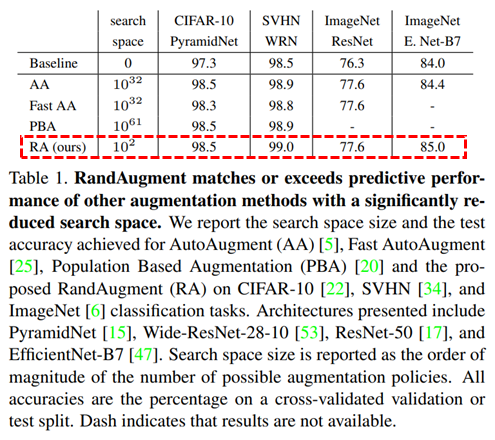

In [1]:
from collections import defaultdict
import random
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from imgaug import augmenters as iaa
import imgaug as ia
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models


In [2]:
trainset = torchvision.datasets.CIFAR10(root='/data', train=True,download=True)
testset = torchvision.datasets.CIFAR10(root='/data', train=False,download=True)
trainset, validset = train_test_split(trainset, test_size=0.2, random_state=42)
len(trainset), len(validset), len(testset)

Files already downloaded and verified
Files already downloaded and verified


(40000, 10000, 10000)

In [15]:
BATCH_SIZE = 512
EPOCHS = 25
IMAGE_SIZE = 72

In [4]:
rand_aug = iaa.RandAugment(n=3, m=7)

def augment(images):
    # Input to `augment()` is a tensor which
    # is not supported by `imgaug`. This is why we first
    # convert it to its `numpy` variant.
    images = np.expand_dims(np.array(images),0)
    return rand_aug(images=images).transpose(0,3,1,2)[0]/255

def non_augment(images):
    images = np.array(images)
    return images.transpose(2,0,1)/255

In [5]:
simple_augment = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomAffine(
         degrees=0.2,
         scale=(0.98,1.02)
     ),
     transforms.ToTensor(),
     # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [6]:
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, aug=None):
        super(AugmentedDataset, self).__init__()
        '''
        '''
        
        if aug == 'simple' :
            self.transform = simple_augment
        elif aug == 'random' :
            self.transform = augment
        else :
            self.transform = non_augment
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        '''
        '''
        sample = self.dataset.__getitem__(index)
        image = sample[0]
        label = sample[1]
        output = {}
        output['image'] = torch.FloatTensor(self.transform(image))
        output['image'] = transforms.Resize((IMAGE_SIZE,IMAGE_SIZE))(output['image'])
        output['label'] = label
        output['index'] = index
        return output

In [7]:
simple_augment_loader = torch.utils.data.DataLoader(AugmentedDataset(trainset, aug='simple'), 
                                          batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
random_augment_loader = torch.utils.data.DataLoader(AugmentedDataset(trainset, aug='random'), 
                                          batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
validloader = torch.utils.data.DataLoader(AugmentedDataset(validset), 
                                          batch_size=BATCH_SIZE, shuffle=False)
testloader = torch.utils.data.DataLoader(AugmentedDataset(testset), 
                                          batch_size=BATCH_SIZE, shuffle=False)
len(simple_augment_loader), len(random_augment_loader), len(validloader), len(testloader)

(78, 78, 20, 20)

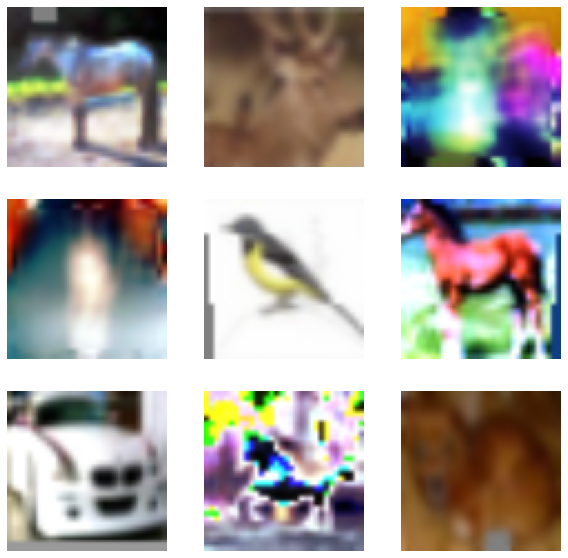

In [8]:
sample = next(iter(random_augment_loader))
sample_images, sample_labels = sample['image'], sample['label']
sample_images = sample_images.permute(0,2,3,1)
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.axis("off")

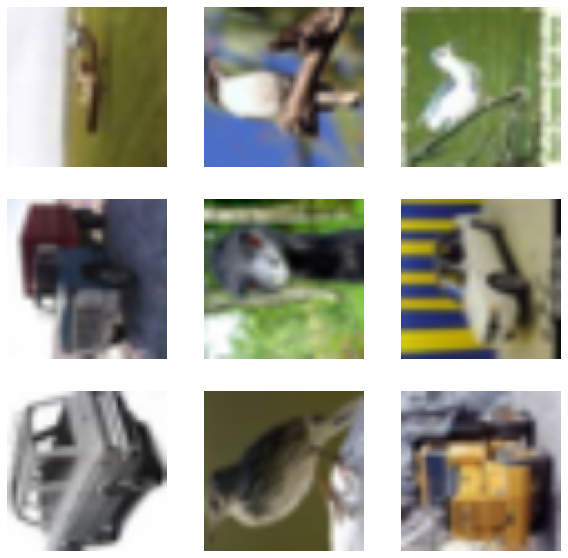

In [9]:
sample = next(iter(simple_augment_loader))
sample_images, sample_labels = sample['image'], sample['label']
sample_images = sample_images.permute(0,2,3,1)
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.axis("off")

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
def get_training_model():
    resnet50 = models.resnet50(pretrained=False, progress=True).to(device)
    resnet50.fc = nn.Linear(2048, 10).to(device)
    
    return resnet50

In [12]:
initial_model = get_training_model()
torch.save(initial_model.state_dict(),"./model/initial_weights.pth")

In [13]:
rand_aug_model = get_training_model()
simple_aug_model = get_training_model()
weight = torch.load("./model/initial_weights.pth")
rand_aug_model.load_state_dict(weight, strict=False)
simple_aug_model.load_state_dict(weight, strict=False)
lr = 1e-3

optimizer1 = torch.optim.Adam(rand_aug_model.parameters(), lr=lr)
optimizer2 = torch.optim.Adam(simple_aug_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [14]:
rand_loss = []
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    rand_aug_model.train()
    for i, data in enumerate(random_augment_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'].to(device), data['label'].to(device)

        # zero the parameter gradients
        optimizer1.zero_grad()

        # forward + backward + optimize
        outputs = rand_aug_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer1.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 20 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0
    
    rand_aug_model.eval()
    with torch.no_grad() :
        true = []
        pred = []
        best_v_loss = 10000.0
        valid_loss = 0
        for i, data in enumerate(validloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data['image'].to(device), data['label'].to(device)

            # zero the parameter gradients
            optimizer1.zero_grad()

            # forward + backward + optimize
            outputs = rand_aug_model(inputs)
            loss = criterion(outputs, labels)

            pred.append(outputs.argmax(dim=1))
            true.append(labels)
            valid_loss += len(inputs)*loss
        true = torch.cat(true, dim=0)
        pred = torch.cat(pred, dim=0)
        correct_predictions = pred.eq(true).sum()
        accuracy = correct_predictions / len(validset) * 100
        v_loss_mean = valid_loss.cpu().numpy()/len(validset)
        rand_loss.append(v_loss_mean)
        if v_loss_mean < best_v_loss :
            best_v_loss = v_loss_mean
            torch.save(rand_aug_model.state_dict(), "./model/randaugment_weights.pth")
    print('validation acc : {:.2f}% \t validation loss : {:.4f}'.format(
        accuracy.cpu().numpy(), v_loss_mean))

print('Finished Training')

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,    20] loss: 2.652
[1,    40] loss: 2.108
[1,    60] loss: 1.922
validation acc : 34.28% 	 validation loss : 1.8730
[2,    20] loss: 1.798
[2,    40] loss: 1.743
[2,    60] loss: 1.656
validation acc : 48.40% 	 validation loss : 1.4101
[3,    20] loss: 1.583
[3,    40] loss: 1.589
[3,    60] loss: 1.508
validation acc : 54.55% 	 validation loss : 1.2669
[4,    20] loss: 1.439
[4,    40] loss: 1.409
[4,    60] loss: 1.374
validation acc : 54.53% 	 validation loss : 1.2957
[5,    20] loss: 1.310
[5,    40] loss: 1.291
[5,    60] loss: 1.271
validation acc : 61.57% 	 validation loss : 1.0934
[6,    20] loss: 1.213
[6,    40] loss: 1.188
[6,    60] loss: 1.169
validation acc : 60.05% 	 validation loss : 1.1994
[7,    20] loss: 1.112
[7,    40] loss: 1.129
[7,    60] loss: 1.107
validation acc : 62.64% 	 validation loss : 1.0886
[8,    20] loss: 1.064
[8,    40] loss: 1.053
[8,    60] loss: 1.043
validation acc : 61.38% 	 validation loss : 1.1347
[9,    20] loss: 0.970
[9,    40] loss: 

KeyboardInterrupt: 

In [16]:
simple_loss = []
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    simple_aug_model.train()
    for i, data in enumerate(simple_augment_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'].to(device), data['label'].to(device)

        # zero the parameter gradients
        optimizer2.zero_grad()

        # forward + backward + optimize
        outputs = simple_aug_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 20 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0
    
    simple_aug_model.eval()
    with torch.no_grad() :
        true = []
        pred = []
        
        best_v_loss = 10000.0
        valid_loss = 0
        for i, data in enumerate(validloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data['image'].to(device), data['label'].to(device)

            # zero the parameter gradients
            optimizer2.zero_grad()

            # forward + backward + optimize
            outputs = simple_aug_model(inputs)
            loss = criterion(outputs, labels)

            pred.append(outputs.argmax(dim=1))
            true.append(labels)
            valid_loss += len(inputs)*loss
        true = torch.cat(true, dim=0)
        pred = torch.cat(pred, dim=0)
        correct_predictions = pred.eq(true).sum()
        accuracy = correct_predictions / len(validset) * 100
        v_loss_mean = valid_loss.cpu().numpy()/len(validset)
        simple_loss.append(v_loss_mean)
        if v_loss_mean < best_v_loss :
            best_v_loss = v_loss_mean
            torch.save(simple_aug_model.state_dict(), "./model/simpleaugment_weights.pth")
    print('validation acc : {:.2f}% \t validation loss : {:.4f}'.format(
        accuracy.cpu().numpy(), v_loss_mean))

print('Finished Training')

[1,    20] loss: 2.426
[1,    40] loss: 1.705
[1,    60] loss: 1.527
validation acc : 46.70% 	 validation loss : 1.4830
[2,    20] loss: 1.267
[2,    40] loss: 1.253
[2,    60] loss: 1.177
validation acc : 51.40% 	 validation loss : 1.4702
[3,    20] loss: 1.030
[3,    40] loss: 1.025
[3,    60] loss: 1.005
validation acc : 57.03% 	 validation loss : 1.2198
[4,    20] loss: 0.865
[4,    40] loss: 0.866
[4,    60] loss: 0.879
validation acc : 55.77% 	 validation loss : 1.3209
[5,    20] loss: 0.779
[5,    40] loss: 0.771
[5,    60] loss: 0.767
validation acc : 65.91% 	 validation loss : 1.0008
[6,    20] loss: 0.633
[6,    40] loss: 0.620
[6,    60] loss: 0.682
validation acc : 68.78% 	 validation loss : 0.9289
[7,    20] loss: 0.526
[7,    40] loss: 0.554
[7,    60] loss: 0.597
validation acc : 67.95% 	 validation loss : 1.0063
[8,    20] loss: 0.469
[8,    40] loss: 0.526
[8,    60] loss: 0.523
validation acc : 69.72% 	 validation loss : 0.9896
[9,    20] loss: 0.387
[9,    40] loss: 

In [17]:
rand_aug_model.eval()
with torch.no_grad() :
    true = []
    pred = []
    test_loss = 0
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'].to(device), data['label'].to(device)

        # zero the parameter gradients
        optimizer2.zero_grad()

        # forward + backward + optimize
        outputs = rand_aug_model(inputs)
        loss = criterion(outputs, labels)

        pred.append(outputs.argmax(dim=1))
        true.append(labels)
        test_loss += len(inputs)*loss
    true = torch.cat(true, dim=0)
    pred = torch.cat(pred, dim=0)
    correct_predictions = pred.eq(true).sum()
    accuracy = correct_predictions / len(testset) * 100
print('randaugment test acc : {:.2f}% \t test loss : {:.4f}'.format(
    accuracy.cpu().numpy(), test_loss.cpu().numpy()/len(testset)))

simple_aug_model.eval()
with torch.no_grad() :
    true = []
    pred = []
    test_loss = 0
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'].to(device), data['label'].to(device)

        # zero the parameter gradients
        optimizer2.zero_grad()

        # forward + backward + optimize
        outputs = simple_aug_model(inputs)
        loss = criterion(outputs, labels)

        pred.append(outputs.argmax(dim=1))
        true.append(labels)
        test_loss += len(inputs)*loss
    true = torch.cat(true, dim=0)
    pred = torch.cat(pred, dim=0)
    correct_predictions = pred.eq(true).sum()
    accuracy = correct_predictions / len(testset) * 100
print('simpleaugment test acc : {:.2f}% \t test loss : {:.4f}'.format(
    accuracy.cpu().numpy(), test_loss.cpu().numpy()/len(testset)))

randaugment test acc : 80.66% 	 test loss : 0.5830
simpleaugment test acc : 73.80% 	 test loss : 1.2275


In [21]:
# rand_loss = [1.8730, 1.4101, 1.2669, 1.2957, 1.0934, 1.1994, 1.0886, 1.1347, 1.1465, 0.9088, 1.0048, 0.7562, 0.7891, 1.2531, 0.7453, 0.6723, 0.7317, 0.6789, 0.7390, 0.5738, 0.7725, 0.8398, 0.5163, 0.5701, 0.6906]
# simple_loss = [1.4830, 1.4702, 1.2198, 1.3209, 1.0008, 0.9289, 1.0063, 0.9896, 0.8199, 0.9283, 0.9862, 0.9089, 0.8585, 1.1080, 1.0017, 0.9761, 1.2343, 0.9612, 1.0558, 1.1258, 1.0972, 1.4664, 0.9992, 1.0448, 1.1558]

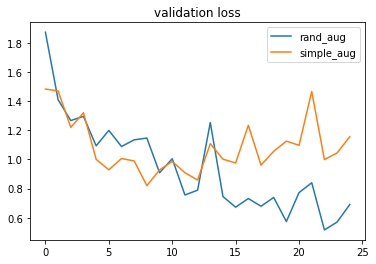

In [28]:
plt.plot(rand_loss, label='rand_aug')
plt.plot(simple_loss, label='simple_aug')
plt.legend()
plt.title('validation loss')
plt.show()

### Augmentation list

##### https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

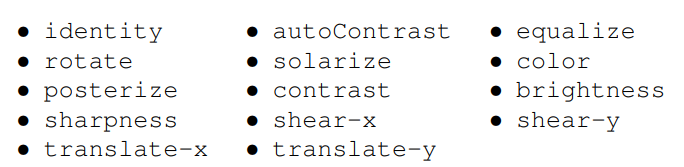

### RandAugment used as Strong Augmentation method for Self-supervised or Semi-supervised Learning

#### FixMatch : Semi-supervised Learning

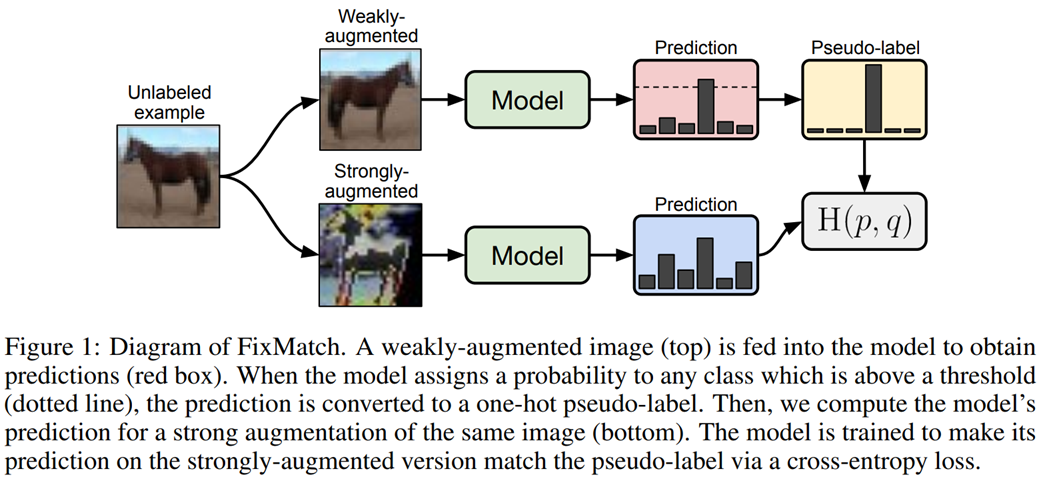

#### SCAN : Image clustering (Self-labeling)

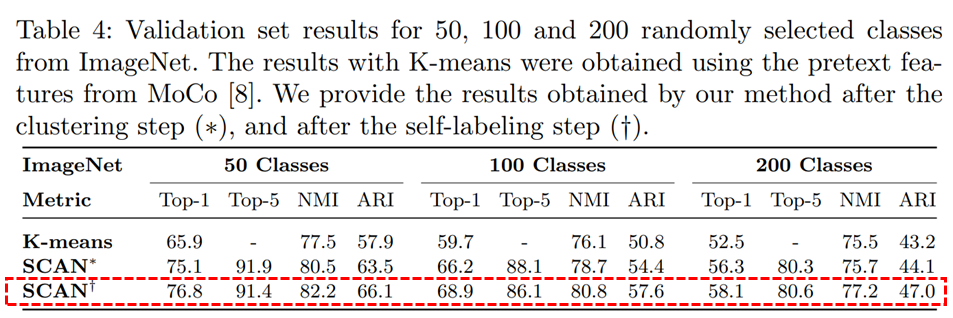